# 2 Learning a policy via MC - Policy Iteration

In [57]:
import numpy as np

# inspired by: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py
BOARD_ROWS = 3
BOARD_COLS = 5
# states = 3x5
WIN_STATE = (0, 2)
LOSE_STATE_I = (1, 0)
#LOSE_STATE_II = (1, 4)
LOSE_STATE_II = (10, 10)
START = (2, 2)
WALL = (1, 2)
DETERMINISTIC = True

class GridWorld(): 
    def __init__(self, state=START):
        # Initialize GridWorld board
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])

        self.state = state
        self.det = DETERMINISTIC
        
    def giveReward(self):
        if self.state == WIN_STATE:
            return 1
        elif (self.state == LOSE_STATE_I) or (self.state == LOSE_STATE_II):
            return -1
        else:
            return 0

    def nextPosition(self, action):
        """
        action: up, down, left, right
        return: next position
        """
        if self.det:
            if action == 0:
                nextState = (self.state[0] - 1, self.state[1])
            elif action == 1:
                nextState = (self.state[0] + 1, self.state[1])
            elif action == 2:
                nextState = (self.state[0], self.state[1] - 1)
            else: 
                nextState = (self.state[0], self.state[1] + 1)
            # if next state legal aka. if field is free
            if (nextState[0] >= 0) and (nextState[0] <= (BOARD_ROWS -1)):  
                if (nextState[1] >= 0) and (nextState[1] <= (BOARD_COLS -1)):
                    if nextState != WALL:
                        return nextState
            return self.state

    def showBoard(self):
        """Show the GridWorld playfield in ASCII art"""
        self.board[self.state] = 1
        # Wall / barrier
        self.board[1,2] = -1
        # Win / Lose states
        self.board[WIN_STATE] = 2
        self.board[LOSE_STATE_I] = -2
        self.board[LOSE_STATE_II] = -2
        for i in range(0, BOARD_ROWS):
            print('-----------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                # Player
                if self.board[i, j] == 1:
                    token = '*'
                # Wall / barrier
                if self.board[i, j] == -1:
                    token = 'z'
                # Free fields
                if self.board[i, j] == 0:
                    token = '0'
                # Win state
                if self.board[i, j] == 2:
                    token = 'W'
                # Lose state
                if self.board[i, j] == -2:
                    token = 'L'
                out += token + ' | '
            print(out)
        print('-----------------')

GW = GridWorld()

# 3 Implementing a policy
## 3.1 Implement the basic agent & 3.2 Evaluate the policy

In [65]:
class Agent():
    def __init__(self):
        self.GW = GridWorld()
        self.end = False
        
        # state-action values
        self.q_table = np.random.rand(3,5,4) # Gridworld x Actions
        
        self.return_table = np.zeros((3,5,4)) # stores the sum of returns
        self.visits_table = np.zeros((3,5,4)) # stores the number of visits
        
        self.returns = []
    
        self.epsilon = 1
        self.epsilon_decay = 0.9999

    
    # epsilon soft policy
    def epsilon_policy(self, epsilon, state): 
        if np.random.rand() > epsilon:
          action = np.argmax(self.q_table[state]) 
        else:
          action = np.random.randint(0,4)
        return action

    
    def makeAct(self, action):
        self.GW.state = self.GW.nextPosition(action)
        self.reward = self.GW.giveReward()
        if self.reward==1 or self.reward==-1:
            # End game
            self.end = True
        #self.state_values[self.GW.state]
    
    def reset(self):
        self.GW = GridWorld()
        self.end = False

    def play(self):
        i = 0
        
        # Create empty list to safe states where the agent was in this episode
        self.state_action_list = []
        
        # Create empty dictionary to safe MC-estimates
        self.erg = {}

        while self.end==False:
            
            state = self.GW.state
            action = self.epsilon_policy(self.epsilon, state)
            self.epsilon *= self.epsilon_decay
            
            self.makeAct(action)
            
            self.state_action_list.append((self.GW.state, action))
            #print(state, action)
        
        self.returns.append(self.reward) # works because the total return is the same as the first non-zero reward
        
        for entry in self.state_action_list:
            sx = entry[0][0]
            sy = entry[0][1]
            a = entry[1]
            self.return_table[sx,sy,a] += self.reward # sum of returns over all runs
            self.visits_table[sx,sy,a] += 1 # number of visits over all runs
            
            self.q_table[sx,sy,a] = self.return_table[sx,sy,a] / self.visits_table[sx,sy,a] # average of returns over all runs
        

        #print(self.q_table.round(2))
        self.reset()
        
#ag = Agent()
#ag.play()

# Policy Iteration

In [112]:
#FIXME: tends to get stuck in some episode every other run
import time
ag = Agent()

times = []
start_time = time.time()
for k in range(1,5001):
    ag.play()
    times.append(time.time() - start_time)
    print(k, np.round(np.average(ag.returns),3), np.round(ag.epsilon, 3)) 

    
r = np.array(ag.returns)
print(np.count_nonzero(r > 0), "positive runs")
print(np.count_nonzero(r < 0), "negative runs")



1 1.0 1.0
2 0.0 0.998
3 -0.333 0.998
4 0.0 0.992
5 -0.2 0.988
6 -0.333 0.987
7 -0.429 0.986
8 -0.5 0.986
9 -0.333 0.985
10 -0.2 0.983
11 -0.091 0.982
12 0.0 0.98
13 -0.077 0.979
14 -0.143 0.979
15 -0.067 0.975
16 -0.125 0.974
17 -0.176 0.971
18 -0.222 0.971
19 -0.158 0.97
20 -0.1 0.967
21 -0.143 0.965
22 -0.091 0.962
23 -0.043 0.96
24 0.0 0.96
25 0.04 0.959
26 0.077 0.956
27 0.037 0.955
28 0.0 0.954
29 0.034 0.953
30 0.0 0.953
31 0.032 0.952
32 0.062 0.949
33 0.03 0.948
34 0.059 0.946
35 0.086 0.945
36 0.111 0.944
37 0.081 0.944
38 0.053 0.943
39 0.077 0.941
40 0.05 0.94
41 0.073 0.936
42 0.095 0.936
43 0.116 0.934
44 0.091 0.928
45 0.067 0.928
46 0.043 0.927
47 0.021 0.917
48 0.0 0.916
49 -0.02 0.915
50 0.0 0.914
51 -0.02 0.913
52 -0.038 0.913
53 -0.057 0.913
54 -0.074 0.911
55 -0.091 0.91
56 -0.071 0.908
57 -0.088 0.905
58 -0.103 0.902
59 -0.119 0.901
60 -0.133 0.901
61 -0.115 0.897
62 -0.129 0.891
63 -0.143 0.889
64 -0.156 0.885
65 -0.169 0.881
66 -0.182 0.879
67 -0.164 0.877
68 -0.

2447 -0.765 0.095
2448 -0.765 0.095
2449 -0.765 0.095
2450 -0.765 0.095
2451 -0.765 0.095
2452 -0.765 0.095
2453 -0.765 0.095
2454 -0.765 0.095
2455 -0.765 0.095
2456 -0.765 0.095
2457 -0.766 0.095
2458 -0.766 0.095
2459 -0.766 0.095
2460 -0.766 0.095
2461 -0.766 0.095
2462 -0.766 0.095
2463 -0.766 0.095
2464 -0.766 0.095
2465 -0.766 0.095
2466 -0.766 0.095
2467 -0.767 0.095
2468 -0.767 0.094
2469 -0.767 0.094
2470 -0.767 0.094
2471 -0.767 0.094
2472 -0.767 0.094
2473 -0.767 0.094
2474 -0.767 0.094
2475 -0.767 0.094
2476 -0.767 0.094
2477 -0.767 0.094
2478 -0.768 0.094
2479 -0.768 0.094
2480 -0.768 0.094
2481 -0.768 0.094
2482 -0.768 0.094
2483 -0.768 0.094
2484 -0.768 0.094
2485 -0.768 0.094
2486 -0.768 0.094
2487 -0.768 0.094
2488 -0.768 0.094
2489 -0.769 0.094
2490 -0.769 0.094
2491 -0.769 0.094
2492 -0.769 0.094
2493 -0.769 0.094
2494 -0.769 0.094
2495 -0.769 0.094
2496 -0.769 0.094
2497 -0.769 0.094
2498 -0.769 0.094
2499 -0.77 0.094
2500 -0.77 0.094
2501 -0.77 0.094
2502 -0.77 0.

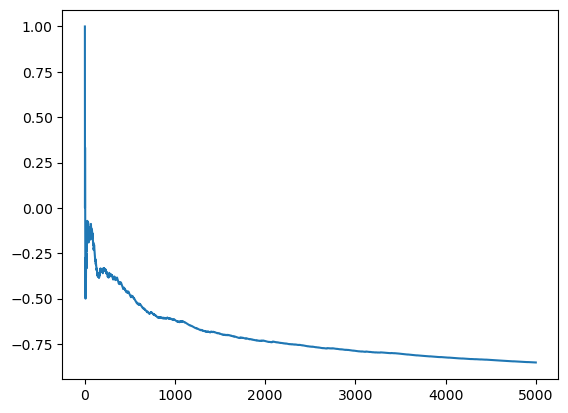

In [107]:
from matplotlib import pyplot
avg_returns = []

for k in range(len(ag.returns)):
    avg_returns.append(np.average(ag.returns[0:k]))

mpl.pyplot.plot(avg_returns)    

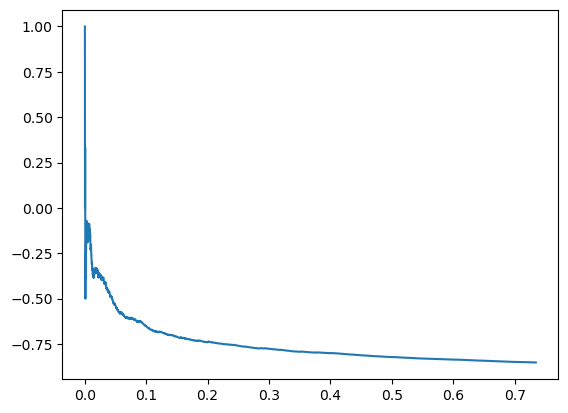

In [110]:
mpl.pyplot.plot(times, avg_returns)